In [46]:
import os
from glob import glob 
import pandas as pd 
from xml.etree import ElementTree as et 
from functools import reduce
from shutil import move 

In [1]:
# import warnings
# warnings.filterwarnings('ignore')

In [9]:
# step-1: get path of each xml file
xmlfiles = glob('./data-img/*.xml')

# replace \\ with /
replace_text = lambda x: x.replace('\\', '/')
xmlfiles = list(map(replace_text, xmlfiles))

In [10]:
xmlfiles[:5], len(xmlfiles)

(['./data-img/bicycle_00.xml',
  './data-img/bicycle_01.xml',
  './data-img/bicycle_02.xml',
  './data-img/bicycle_03.xml',
  './data-img/bicycle_04.xml'],
 458)

In [47]:
# step-2: read xml files
# from each xml file extract
# filename, size(width, height), object(name, xmin, xmax, ymin, ymax)

def extract_text(filename):
    tree = et.parse(filename)
    root = tree.getroot()

    # extract filename
    image_name = root.find('filename').text
    
    # width and height of the image
    width = root.find('size').find('width').text
    height = root.find('size').find('height').text
    objs = root.findall('object')
    
    parser = []
    for obj in objs:
        name = obj.find('name').text
        bndbox = obj.find('bndbox')
        xmin = bndbox.find('xmin').text
        xmax = bndbox.find('xmax').text
        ymin = bndbox.find('ymin').text
        ymax = bndbox.find('ymax').text
        parser.append([image_name, width, height, name, xmin, xmax, ymin, ymax])
        
    return parser

In [12]:
parser_all = list(map(extract_text, xmlfiles)) 

In [14]:
parser_all[0]

[['bicycle_00.jpg', '800', '600', 'bicycle', '158', '514', '244', '512']]

In [15]:
data = reduce(lambda x, y: x + y, parser_all) 

In [24]:
data[:5]

[['bicycle_00.jpg', '800', '600', 'bicycle', '158', '514', '244', '512'],
 ['bicycle_01.jpg', '2048', '1536', 'bicycle', '78', '1954', '46', '1407'],
 ['bicycle_02.jpg', '1337', '2048', 'bicycle', '207', '1160', '150', '2048'],
 ['bicycle_03.jpg', '2048', '1536', 'bicycle', '3', '1744', '169', '1364'],
 ['bicycle_04.jpg', '2048', '1364', 'bicycle', '261', '1831', '134', '1275']]

In [17]:
col = ['filename', 'width', 'height', 'name', 'xmin', 'xmax', 'ymin', 'ymax']
df = pd.DataFrame(data, columns=col) 
df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax
0,bicycle_00.jpg,800,600,bicycle,158,514,244,512
1,bicycle_01.jpg,2048,1536,bicycle,78,1954,46,1407
2,bicycle_02.jpg,1337,2048,bicycle,207,1160,150,2048
3,bicycle_03.jpg,2048,1536,bicycle,3,1744,169,1364
4,bicycle_04.jpg,2048,1364,bicycle,261,1831,134,1275


In [25]:
df.shape

(754, 8)

In [26]:
# df['name'].value_counts()
df.name.value_counts() 

name
person          80
chair           66
bottle          65
dog             50
sheep           49
potted plant    44
cow             38
horse           34
boat            33
car             33
cat             32
bus             31
motor bike      29
bicycle         27
bird            27
train           26
tv monitor      25
dining table    23
aeroplane       21
sofa            21
Name: count, dtype: int64

#### Conversion
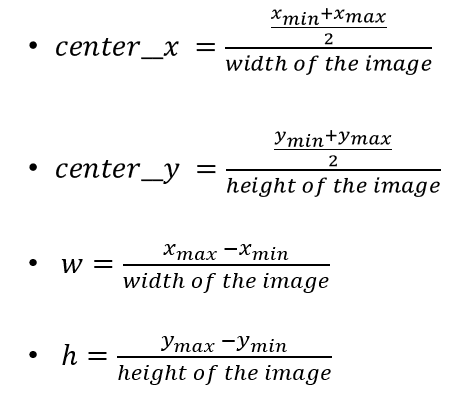

In [27]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  754 non-null    object
 1   width     754 non-null    object
 2   height    754 non-null    object
 3   name      754 non-null    object
 4   xmin      754 non-null    object
 5   xmax      754 non-null    object
 6   ymin      754 non-null    object
 7   ymax      754 non-null    object
dtypes: object(8)
memory usage: 47.2+ KB


In [28]:
# type conversion
cols = ['width', 'height', 'xmin', 'xmax', 'ymin', 'ymax']
df[cols] = df[cols].astype(int)
df.info() 

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 754 entries, 0 to 753
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  754 non-null    object
 1   width     754 non-null    int32 
 2   height    754 non-null    int32 
 3   name      754 non-null    object
 4   xmin      754 non-null    int32 
 5   xmax      754 non-null    int32 
 6   ymin      754 non-null    int32 
 7   ymax      754 non-null    int32 
dtypes: int32(6), object(2)
memory usage: 29.6+ KB


In [29]:
# center x, 
df['center_x'] = ((df['xmax'] + df['xmin']) / 2) / df['width']
# center y
df['center_y'] = ((df['ymax'] + df['ymin']) / 2) / df['height']
# w 
df['w'] = (df['xmax'] - df['xmin']) / df['width']
# h 
df['h'] = (df['ymax'] - df['ymin']) / df['height'] 

In [30]:
df.head()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
0,bicycle_00.jpg,800,600,bicycle,158,514,244,512,0.420000,0.630000,0.445000,0.446667
1,bicycle_01.jpg,2048,1536,bicycle,78,1954,46,1407,0.496094,0.472982,0.916016,0.886068
2,bicycle_02.jpg,1337,2048,bicycle,207,1160,150,2048,0.511219,0.536621,0.712790,0.926758
3,bicycle_03.jpg,2048,1536,bicycle,3,1744,169,1364,0.426514,0.499023,0.850098,0.777995
4,bicycle_04.jpg,2048,1364,bicycle,261,1831,134,1275,0.510742,0.516496,0.766602,0.836510


In [35]:
images = df['filename'].unique() 
len(images)

458

In [36]:
# 80% train and 20% test
img_df = pd.DataFrame(images, columns=['filename'])
img_train = tuple(img_df.sample(frac=0.8)['filename']) 
img_test = tuple(img_df.query(f'filename not in {img_train}')['filename']) 
len(img_train), len(img_test)

(366, 92)

In [40]:
train_df = df.query(f'filename in {img_train}')
print(len(train_df))
train_df.head()

614


,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
1,bicycle_01.jpg,2048,1536,bicycle,78,1954,46,1407,0.496094,0.472982,0.916016,0.886068
2,bicycle_02.jpg,1337,2048,bicycle,207,1160,150,2048,0.511219,0.536621,0.712790,0.926758
7,bicycle_07.jpg,1024,804,bicycle,1,830,298,804,0.405762,0.685323,0.809570,0.629353
13,bicycle_10.jpg,2048,1536,bicycle,24,2044,144,1316,0.504883,0.475260,0.986328,0.763021
14,bicycle_11.jpg,1600,1200,bicycle,88,991,110,809,0.337187,0.382917,0.564375,0.582500


In [41]:
test_df = df.query(f'filename in {img_test}')
print(len(test_df))
test_df.head()

140


,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h
0,bicycle_00.jpg,800,600,bicycle,158,514,244,512,0.420000,0.630000,0.445000,0.446667
3,bicycle_03.jpg,2048,1536,bicycle,3,1744,169,1364,0.426514,0.499023,0.850098,0.777995
4,bicycle_04.jpg,2048,1364,bicycle,261,1831,134,1275,0.510742,0.516496,0.766602,0.836510
5,bicycle_05.jpg,900,600,bicycle,338,692,38,525,0.572222,0.469167,0.393333,0.811667
6,bicycle_06.jpg,2048,1365,bicycle,137,1967,182,1292,0.513672,0.539927,0.893555,0.813187


In [42]:
# label encoding
def label_encoding(x):
    labels = {'person':0, 'car':1, 'chair':2, 'bottle':3, 'potted plant':4, 'bird':5, 'dog':6,
       'sofa':7, 'bicycle':8, 'horse':9, 'boat':10, 'motor bike':11, 'cat':12, 'tv monitor':13,
       'cow':14, 'sheep':15, 'aeroplane':16, 'train':17, 'dining table':18, 'bus':19}
    return labels[x]

In [43]:
train_df['id'] = train_df['name'].apply(label_encoding)
test_df['id'] = test_df['name'].apply(label_encoding)

C:\Users\Amuni Pelumi\AppData\Local\Temp\ipykernel_12868\3116627190.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_df['id'] = train_df['name'].apply(label_encoding)
C:\Users\Amuni Pelumi\AppData\Local\Temp\ipykernel_12868\3116627190.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df['id'] = test_df['name'].apply(label_encoding)


In [44]:
train_df.head(10)

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h,id
1,bicycle_01.jpg,2048,1536,bicycle,78,1954,46,1407,0.496094,0.472982,0.916016,0.886068,8
2,bicycle_02.jpg,1337,2048,bicycle,207,1160,150,2048,0.511219,0.536621,0.712790,0.926758,8
7,bicycle_07.jpg,1024,804,bicycle,1,830,298,804,0.405762,0.685323,0.809570,0.629353,8
13,bicycle_10.jpg,2048,1536,bicycle,24,2044,144,1316,0.504883,0.475260,0.986328,0.763021,8
14,bicycle_11.jpg,1600,1200,bicycle,88,991,110,809,0.337187,0.382917,0.564375,0.582500,8
15,bicycle_11.jpg,1600,1200,bicycle,172,1462,171,1183,0.510625,0.564167,0.806250,0.843333,8
16,bicycle_11.jpg,1600,1200,bicycle,746,1591,271,1148,0.730313,0.591250,0.528125,0.730833,8
17,bicycle_12.jpg,2048,1536,bicycle,628,2048,2,1536,0.653320,0.500651,0.693359,0.998698,8
18,bicycle_13.jpg,2047,1365,bicycle,521,1767,207,1255,0.558867,0.535531,0.608696,0.767766,8
19,bicycle_14.jpg,800,535,bicycle,290,731,189,457,0.638125,0.603738,0.551250,0.500935,8


In [45]:
test_df.tail()

,filename,width,height,name,xmin,xmax,ymin,ymax,center_x,center_y,w,h,id
738,train_10.jpg,800,600,train,1,800,264,435,0.500625,0.582500,0.998750,0.285000,17
743,train_15.jpg,1024,768,train,2,449,235,670,0.220215,0.589193,0.436523,0.566406,17
744,train_15.jpg,1024,768,train,501,1023,245,665,0.744141,0.592448,0.509766,0.546875,17
751,train_22.jpg,2048,868,train,56,862,148,443,0.224121,0.340438,0.393555,0.339862,17
752,train_22.jpg,2048,868,train,1003,2033,146,412,0.741211,0.321429,0.502930,0.306452,17


In [48]:
train_folder = 'data-img/train'
test_folder = 'data-img/test'

os.mkdir(train_folder)
os.mkdir(test_folder) 

In [50]:
cols = ['filename', 'id', 'center_x', 'center_y', 'w', 'h']
groupby_obj_train = train_df[cols].groupby('filename')
groupby_obj_test = test_df[cols].groupby('filename') 

In [53]:
groupby_obj_train.get_group('bicycle_14.jpg')

,filename,id,center_x,center_y,w,h
19,bicycle_14.jpg,8,0.638125,0.603738,0.55125,0.500935


In [57]:
def save_data(filename, folder_path, group_obj):
    src = os.path.join('data-img', filename)
    dst = os.path.join(folder_path, filename)
    move(src, dst) 
    
    text_filename = os.path.join(folder_path, os.path.splitext(filename)[0] + '.txt')
    group_obj.get_group(filename).set_index('filename').to_csv(text_filename, sep=' ',index=False, header=False)

In [58]:
filename_series = pd.Series(groupby_obj_train.groups.keys())
filename_series

0      bicycle_01.jpg
1      bicycle_02.jpg
2      bicycle_07.jpg
3      bicycle_10.jpg
4      bicycle_11.jpg
            ...      
361      train_18.jpg
362      train_19.jpg
363      train_20.jpg
364      train_21.jpg
365      train_23.jpg
Length: 366, dtype: object

In [59]:
filename_series.apply(save_data, args=(train_folder, groupby_obj_train)) 

0      None
1      None
2      None
3      None
4      None
       ... 
361    None
362    None
363    None
364    None
365    None
Length: 366, dtype: object

In [60]:
filename_series_test = pd.Series(groupby_obj_test.groups.keys())
filename_series_test.apply(save_data, args=(test_folder, groupby_obj_test))

0     None
1     None
2     None
3     None
4     None
      ... 
87    None
88    None
89    None
90    None
91    None
Length: 92, dtype: object